# Deepfake Detection - Comparing Face Detectors

In this notebook, we will be comparing the different open source face detectors.

1. **MTCNN**
    *https://github.com/ipazc/mtcnn*
2. **RetinaFace**
    *https://github.com/serengil/retinaface*

In [1]:
import cv2
import numpy as np
import os
import time

from PIL import Image

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

## Load and Output

In [3]:
multiface_image = "sample-images/multiple-faces.jpg"
img = cv2.imread(multiface_image)

### MTCNN

MTCNN outputs a list of identified faces.

In [4]:
tic = time.time()
from mtcnn import MTCNN

mtcnn = MTCNN()
timeA = time.time()

res = mtcnn.detect_faces(img)

timeB = time.time()
print("Load time :", timeA-tic)
print("Run time  :", timeB-timeA)
display(res)

Metal device set to: AMD Radeon Pro 5500M
Load time : 6.154065847396851
Run time  : 2.7601611614227295


[{'box': [1296, 48, 251, 307],
  'confidence': 0.9902481436729431,
  'keypoints': {'left_eye': (1398, 161),
   'right_eye': (1514, 156),
   'nose': (1478, 204),
   'mouth_left': (1420, 284),
   'mouth_right': (1521, 277)}},
 {'box': [236, 191, 216, 276],
  'confidence': 0.9727864861488342,
  'keypoints': {'left_eye': (276, 296),
   'right_eye': (371, 295),
   'nose': (303, 349),
   'mouth_left': (281, 399),
   'mouth_right': (368, 399)}}]

### RetinaFace

RetinaFace outputs a dictionary of different faces.

In [5]:
time0 = time.time()
from retinaface import RetinaFace

time1 = time.time()

res = RetinaFace.detect_faces(img)
time2 = time.time()

print("Load time :", time1-time0)
print("Run time  :", time2-time1)

display(res)

Load time : 0.10487222671508789
Run time  : 4.358954906463623


{'face_1': {'score': 0.9997426867485046,
  'facial_area': [253, 177, 470, 477],
  'landmarks': {'right_eye': [280.83682, 297.97144],
   'left_eye': [363.45413, 296.69656],
   'nose': [292.15662, 355.32697],
   'mouth_right': [288.2101, 400.1632],
   'mouth_left': [361.88803, 399.48785]}},
 'face_2': {'score': 0.9996591806411743,
  'facial_area': [1308, 41, 1560, 380],
  'landmarks': {'right_eye': [1417.3353, 154.22382],
   'left_eye': [1521.9045, 156.9613],
   'nose': [1504.0908, 202.60379],
   'mouth_right': [1430.2915, 275.61765],
   'mouth_left': [1525.5427, 277.45453]}}}

## Evaluation times

Note: MTCNN is using tensorflow-metal, the GPU backend for tensorflow on MacOS.

In [6]:
sample_images = [
  'sample-images/sample0.png',
  'sample-images/sample1.png',
  'sample-images/sample2.png',
  'sample-images/sample3.png',
  'sample-images/sample4.png'
]

In [7]:
# MTCNN
mtcnn_times = []
mtcnn_results = {}
for path in sample_images:
  img = cv2.imread(path)
  stime = time.time()
  res = mtcnn.detect_faces(img)
  etime = time.time()
  mtcnn_results[path] = res
  mtcnn_times.append(etime-stime)
  
mtcnn_avg = sum(mtcnn_times)/len(mtcnn_times)
mtcnn_avg

1.9687812805175782

In [8]:
# RetinaFace
rf_times = []
rf_results = {}
for path in sample_images:
  img = cv2.imread(path)
  stime = time.time()
  res = RetinaFace.detect_faces(img)
  etime = time.time()
  rf_results[path] = res
  rf_times.append(etime-stime)
  
rf_avg = sum(rf_times)/len(rf_times)
rf_avg

0.6691904067993164

## Drawing Faces

In [9]:
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from typing import List, Union

AVAILABLE_MODELS = ["mtcnn", "retinaface"]

class DetectorCmap:
  """
  Custom cmap.
  Used for drawing 
  
  """
  def __init__(self, l=None):
    if l is None:
      self.cmap = self.set_default_cmap()
    else:
      self.cmap = self.set_cmap(l)

  def set_default_cmap(self):
    c = ["red", "orange", "yellow", "greenyellow", "limegreen"]
    v = [0, .25, .5, .76 , 1.]
    l = list(zip(v,c))
    self.cmap = LinearSegmentedColormap.from_list("ryg", l, N=1000)
    return self.cmap
  
  def set_cmap(self, l):
    self.cmap = LinearSegmentedColormap.from_list("custom", l, N=1000)
    return self.cmap
  
  def get_rgb(self, k:float):
    if k < 0 or k > 1:
      raise ValueError("k value should be between 0 and 1.")
    rgba = self.cmap(k)
    r, g, b = int(rgba[0]*256), int(rgba[1]*256), int(rgba[2]*256)
    return r, g, b

  def display_cmap(self):
    fig, ax = plt.subplots(1,1,figsize=(6,1))
    ax.imshow(np.array([np.arange(1000) for i in range(100)]), cmap=self.cmap)
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([0,500,1000])
    plt.show()
    

class FaceExtractor:
  
  def __init__(self, model:str, thresh:float=0.5):
    if model not in AVAILABLE_MODELS:
      raise Exception(f"{model} not valid.")
    self.model = model
    self.detector = self._initialise_detector()
    self.cmap = DetectorCmap()
    self.thresh = thresh
    
  def _initialise_detector(self) -> None:
    if self.model == "mtcnn":
      from mtcnn import MTCNN
      return MTCNN()
    elif self.model == "retinaface":
      from retinaface import RetinaFace
      return RetinaFace
  
  def draw_face_on_image(self, img: Union[str, np.ndarray], 
                         padding=0.3, width=2):
    """
    Detects a face and draws a rectangle on the image.
    """
    if type(img) == str:
      img = self.open_image(img)
    
    # Image size
    img_y = img.shape[0]
    img_x = img.shape[1]
    
    faces = self.detect_faces(img)
    for face in faces:
      if self.model == "mtcnn":
        x, y, w, h = face['box']
      elif self.model == "retinaface":
        x, y, w, h = face['box']
      if padding:
        x, y, w, h = self.add_padding(x,y,w,h, img_x, img_y, padding)
      confidence = face['confidence']
      box_colour = self.cmap.get_rgb(confidence)
      # Draws the rectangle on the img
      cv2.rectangle(img, (x,y), (x+w, y+h), box_colour , width)
    return img
  
  def crop_detected_face(self, img: Union[str, np.ndarray], padding:float=0.3) -> List[np.ndarray]:
    if type(img) == str:
      img = self.open_image(img)
    img_y = img.shape[0]
    img_x = img.shape[1]
    cropped_images = []
    faces = self.detect_faces(img)
    for face in faces:
      if face['confidence'] > self.thresh:
        x, y, w, h = face['box']
        if padding:
          x, y, w, h = self.add_padding(x,y,w,h, img_x, img_y, padding)
        cropped_images.append(img[y:y+h, x:x+h])
    return cropped_images
  
  def detect_faces(self, img: np.ndarray) -> List:
    faces = []
    results = self.detector.detect_faces(img)
    for res in results:
      if self.model == "mtcnn":
        box = tuple(res['box'])
        confidence = res['confidence']
      elif self.model == "retinaface":
        # If 'res' is not a face key in the results output
        if type(res) is not str: 
          return []
        res = results[res]
        x, y, xmax, ymax = tuple(res['facial_area'])
        w, h = xmax-x, ymax-y
        box = tuple((x, y, w, h))
        confidence = res['score']
      faces.append({
        'box': box,
        'confidence': confidence
      })
    return faces

  def add_padding(self, x:int, y:int, w:int, h:int, xlim: int, ylim: int, 
                  amount:float=0.3) -> tuple:
    """
    Returns the dimensions after a padding amount has been added.
    Defaults to add 30% padding.
    """
    # Adds paddding
    new_w = int(w * (1 + amount)) 
    new_h = int(h * (1 + amount))      
    new_x = x - int( (new_w - w)/2 )
    new_y = y - int( (new_h - h)/2 )
    # Check limits
    if new_w > xlim:
      new_w = xlim
      new_x = 0
    if new_h > ylim:
      new_h = ylim
      new_y = 0
    if new_x < 0:
      new_x = 0
    if new_y < 0:
      new_y = 0
    return new_x, new_y, new_w, new_h
  
  def open_image(self, image_path: str) -> np.ndarray:
    img = cv2.imread(image_path)
    if img is None:
      raise FileNotFoundError(f"{image_path} not found.")
    return img

The DetectorCmap allows us to make a custom cmap that can be used for colouring the bounding boxes for detected faces.

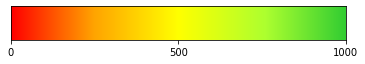

In [48]:
cmap = DetectorCmap()
cmap.display_cmap()

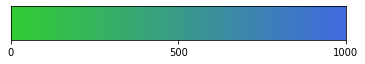

In [54]:
c = ["limegreen", "royalblue"]
v = [0, 1.]
l = list(zip(v,c))
cmap = DetectorCmap(l)
cmap.display_cmap()

In [57]:
cmap.get_rgb(0.8)

(62, 125, 190)

Example:
- For a low confidence level, the color is red
- For a high confidence level, the color is green

In [11]:
cmap.get_rgb(0.123), cmap.get_rgb(0.8910)

((256, 81, 0), (105, 228, 48))

## Tests

In [12]:
face_extractor1 = FaceExtractor("mtcnn")
face_extractor2 = FaceExtractor("retinaface")

### Test 1: Face Yaw

In [13]:
path = "sample-images/sample0.png"
mtcnn_img = face_extractor1.draw_face_on_image(path, padding=0.3, width=10)
rf_img = face_extractor2.draw_face_on_image(path, padding=0.3, width=10)

# Save images
cv2.imwrite("sample-images/sample0-mtcnn.png", mtcnn_img)
cv2.imwrite("sample-images/sample0-retinaface.png", rf_img)

True

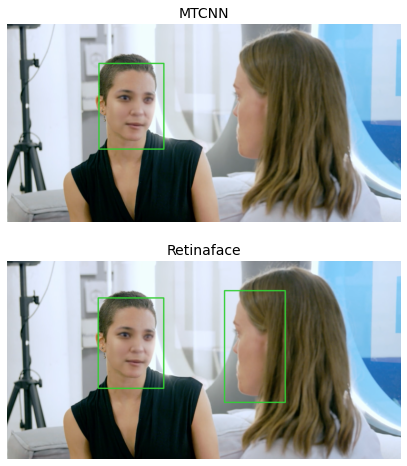

In [14]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
img1 = cv2.imread("sample-images/sample0-mtcnn.png")
img2 = cv2.imread("sample-images/sample0-retinaface.png")
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].set_title("MTCNN", fontsize=14)
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].set_title("Retinaface", fontsize=14)
ax[1].axis('off')
plt.show()

**Conclusion:** MTCNN is unable to detect face yaw whereas Retinaface is able to.

### Test 2: Large faces

In [15]:
path = "sample-images/large-face.jpg"
mtcnn_img = face_extractor1.draw_face_on_image(path, width=10)
rf_img = face_extractor2.draw_face_on_image(path, width=10)

# Save images
cv2.imwrite("sample-images/large-face-mtcnn.png", mtcnn_img)
cv2.imwrite("sample-images/large-face-retinaface.png", rf_img)

True

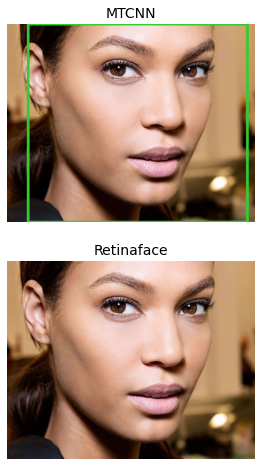

In [16]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
img1 = cv2.imread("sample-images/large-face-mtcnn.png")
img2 = cv2.imread("sample-images/large-face-retinaface.png")
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].set_title("MTCNN", fontsize=14)
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].set_title("Retinaface", fontsize=14)
ax[1].axis('off')
plt.show()

**Conclusion:** MTCNN is able to detect faces that take up most of the frame, whereas Retinaface isn't able to.

## Function tests

1. **Crop function** - if confidence level is high, crop the face with the padding

2. **Image rescaler** - set a size limit for the face size.
3. **Crop best face function**

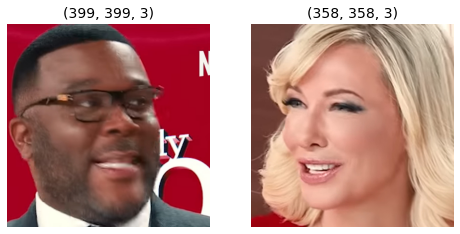

In [17]:
path = "sample-images/multiple-faces.jpg"
cropped_images = face_extractor1.crop_detected_face(path,padding=0.3)

n_images = len(cropped_images)
if n_images > 0:
  fig, ax = plt.subplots(1,n_images,figsize=(8,8))
  for i, img in enumerate(cropped_images):
    if len(cropped_images) > 1:
      ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax[i].set_title(f"{img.shape}", fontsize=14)
      ax[i].axis('off')
    else:
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax.set_title(f"{img.shape}", fontsize=14)
      ax.axis('off')
  plt.show()

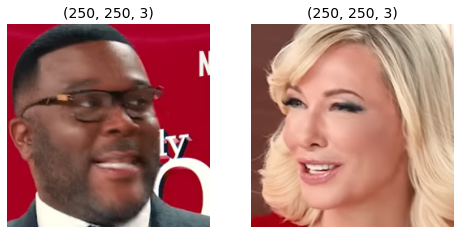

In [18]:
def resize(img: np.ndarray, dim: tuple) -> np.ndarray:
  return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

dim = (250, 250)
cropped_images = [ resize(img, dim) for img in cropped_images ]

n_images = len(cropped_images)
if n_images > 0:
  fig, ax = plt.subplots(1,n_images,figsize=(8,8))
  for i, img in enumerate(cropped_images):
    if len(cropped_images) > 1:
      ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax[i].set_title(f"{img.shape}", fontsize=14)
      ax[i].axis('off')
    else:
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax.set_title(f"{img.shape}", fontsize=14)
      ax.axis('off')
  plt.show()

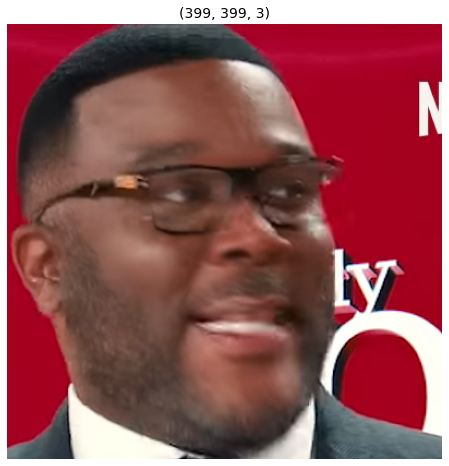

In [19]:
import os
import sys
# Enables import of modules under 'model'
sys.path.append(os.path.dirname(os.getcwd()))

from extractors import FaceExtractor

face_extractor = FaceExtractor(model="mtcnn", thresh=0.87)
face, conf = face_extractor.crop_best_face(path)

cropped_images = [face]
n_images = len(cropped_images)
if n_images > 0:
  fig, ax = plt.subplots(1,n_images,figsize=(8,8))
  for i, img in enumerate(cropped_images):
    if len(cropped_images) > 1:
      ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax[i].set_title(f"{img.shape}", fontsize=14)
      ax[i].axis('off')
    else:
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax.set_title(f"{img.shape}", fontsize=14)
      ax.axis('off')
  plt.show()

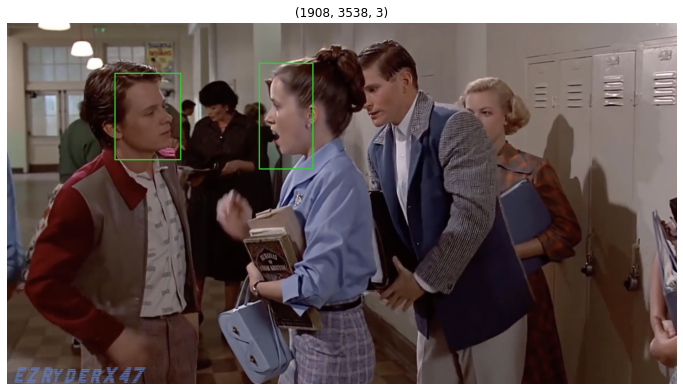

CPU times: user 1.16 s, sys: 274 ms, total: 1.43 s
Wall time: 1.4 s


In [47]:
%%time
path = "sample-images/many-faces.png"
face_extractor = FaceExtractor(model="retinaface", thresh=0.92)
image = face_extractor.draw_face_on_image(path, padding=0.3, width=5, 
                                          sort_by="area", min_area=0.001,
                                         face_limit=2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax.set_title(image.shape)
ax.axis('off')
plt.show()

In [55]:
from extractors import open_image

image = open_image(path)

results = face_extractor.detect_faces(image, sort_by="area")
for face in results:
  face['area'] = face['box'][2] * face['box'][3]
results

[{'box': (1364, 281, 218, 429),
  'confidence': 0.9985313415527344,
  'area': 93522},
 {'box': (610, 322, 267, 350),
  'confidence': 0.9993454813957214,
  'area': 93450},
 {'box': (1846, 225, 230, 329),
  'confidence': 0.999674916267395,
  'area': 75670},
 {'box': (2422, 364, 196, 275),
  'confidence': 0.9980436563491821,
  'area': 53900},
 {'box': (1044, 415, 103, 106),
  'confidence': 0.999171257019043,
  'area': 10918}]

In [65]:
import pandas as pd

data_full = pd.read_csv("../dataset-full.csv")
data_sample = pd.read_csv("../dataset-sample.csv")

data_full.shape, data_sample.shape

((13393, 4), (3048, 4))

In [68]:
# gets random videos from 

test_data = data_full[~data_full.isin(data_sample)].dropna()
test_data["dataset"]

,filename,label,fullpath,dataset
0,aagfhgtpmv.mp4,FAKE,../datasets/Kaggle-dfdc/train_sample_videos/aa...,Kaggle-dfdc
1,aapnvogymq.mp4,FAKE,../datasets/Kaggle-dfdc/train_sample_videos/aa...,Kaggle-dfdc
2,aaqaifqrwn.mp4,FAKE,../datasets/Kaggle-dfdc/dfdc_train_part_0/aaqa...,Kaggle-dfdc
3,aassnaulhq.mp4,FAKE,../datasets/Kaggle-dfdc/dfdc_train_part_1/aass...,Kaggle-dfdc
6,abebnhqyzv.mp4,FAKE,../datasets/Kaggle-dfdc/dfdc_train_part_1/abeb...,Kaggle-dfdc
...,...,...,...,...
13388,28__secret_conversation.mp4,REAL,../datasets/DeepfakeDetectionDataset/original_...,DeepfakeDetectionDataset
13389,28__talking_angry_couch.mp4,REAL,../datasets/DeepfakeDetectionDataset/original_...,DeepfakeDetectionDataset
13390,28__walk_down_hall_angry.mp4,REAL,../datasets/DeepfakeDetectionDataset/original_...,DeepfakeDetectionDataset
13391,28__walking_down_street_outside_angry.mp4,REAL,../datasets/DeepfakeDetectionDataset/original_...,DeepfakeDetectionDataset


In [69]:
test_data["dataset"].value_counts()

Celeb-DF-v2                 6529
DeepfakeDetectionDataset    3431
Kaggle-dfdc                 1633
Name: dataset, dtype: int64

In [76]:
def random_deepfake(dataset="Celeb-DF-v2"):
  sample = test_data[test_data["dataset"]==dataset][test_data["label"]=="FAKE"]
  return sample.sample(n=1)['filename'].iloc[0]

random_deepfake()

'id4_id0_0003.mp4'

In [81]:
def random_deepfake

array([[3, 3],
       [4, 2]])